In [1]:
import matplotlib.pyplot as plt
import numpy as np

### Markus Giftthaler's (co-author of Control ToolBox library) answer:
    
Hi Djorde,
thanks for your mail!
Your question does unfortunately not have a very clear and simple answer. 
The choice of integrator-type is very much dependent on your personal requirements w.r.t. accuracy and speed.
My personal preference is that I often do not use symplectic integrators, simply because energy-drift is not
a big issue for the types of system I consider, e.g. mobile robots. 
Very often, the underlying modeling assumptions or the inaccuracy of your model parameters is very much 
outweighing the effect of energy drift, in such a case, I would use a low-order explicit runge-kutta scheme 
without hesitating. There are some cases, e.g. for oscillators with low damping, where you will be able to 
detect energy-drift, but then it can even be sufficient to simply lower your step-size to get better stability.
So, in a nutshell, it really depends on your requirements and personal preference. 
If you want to reasonable step sizes with good stability and good integration speed, 
I can indeed recommend symplectic (semi-implicit) Euler integrators!
Hope this helps!


### Mujoco integrator discussion: http://www.mujoco.org/book/computation.html#geIntegration

In [2]:
def calc_acc(pos, vel, drag_force, gravity, drag_coefs):
    if drag_force:
        drag = drag_coefs * vel**2
        if abs(gravity) < abs(drag):
            acc = 0.0
        else:
            acc = gravity + drag
        return acc
    else:
        return gravity

In [3]:
###############################################################################
# LEAPFROG 1 integrator 
# Source [The leapfrog method and other “symplectic” algorithms for integrating Newton’s laws of motion]
# Source [Lecture V: Time integration pdf]
# Wikipedia version 1

def integrate_LF(gravity, x0, v0, dt_, N, drag_force, drag_coefs):
    ###########################################################################
    # arrays are allocated and filled with zeros
    x = np.zeros(N)
    v_half = np.zeros(N)
    v_full = np.zeros(N)
    a = np.zeros(N+1)
    
    E = np.zeros(N)    
    Ek = np.zeros(N)
    Ep = np.zeros(N)    
    
    ###########################################################################    
    # initial conditions
    x[0] = x0
    v_full[0] = v0
    a = calc_acc(x[0], v_full[0], drag_force, gravity, drag_coefs)
    
    #calculate intial V_{1/2} 
    v_half[0] = v0 + 0.5 * a * dt_
    
    #calculate intial energy Ek+Ep
    Ek[0] = 0.5 * v_full[0]**2 
    Ep[0] = -1 * a * x[0]
    E[0] = Ek[0] + Ep[0]
    
    ###########################################################################
    # integration    
    for i in range(N-1):
        #update position from n -> n+1
        x[i + 1] = x[i] + dt_ * v_half[i]        
        
        #update velocity from n+1/2 -> n+3/2
        v_half[i + 1] = v_half[i] + dt_ * a
        
        #update velocity from n -> n +1: This may only be correct if a is 
        #constant over complete time horizon...take average of V_1/2 and V_3/2
        #v_full[i + 1] = (v_half[i] + v_half[i+1]) / 2.0 

        #or maybe this is the same
        #as V_{n+1} = V_{n+3/2} - 1/2 * dt * a_{n+1} [Wikipedia], i.e.
        v_full[i + 1] = v_half[i + 1] - 0.5 * dt_ * a

        a = calc_acc(x[i+1], v_full[i + 1], drag_force, gravity, drag_coefs)

        Ek[i + 1] = 0.5 * v_full[i+1]**2 
        Ep[i + 1] =  -1 * a * x[i+1]
        
        #Calcualte energy Ek plus Ep
        E[i + 1] =  Ek[i + 1] + Ep[i + 1]    
        
    ###########################################################################
    # return solution
    return x, v_half, v_full, Ek, Ep, E 

In [4]:
###############################################################################
# LEAPFROG 2 integrator [Wikipedia version 2 ] === Velocity Verlet
# https://www.uio.no/studier/emner/matnat/astro/AST2000/h18/undervisningsmateriell_h2018/Numerical%20Compendium/integration_of_differential_equations.pdf]
#Note, however, that this algorithm assumes that acceleration {n+1}
#only depends on position {n+1} and does not depend on velocity {n+1} {Wikipedia Velocity Verlet}

def integrate_VV(gravity, x0, v0, dt_, N, drag_force, drag_coefs):
    ###########################################################################
    # arrays are allocated and filled with zeros
    x = np.zeros(N)
    v_half = np.zeros(N)
    v_full = np.zeros(N)
    a = np.zeros(N+1)
    E = np.zeros(N)    
    Ek = np.zeros(N)
    Ep = np.zeros(N) 
    
    ###########################################################################    
    # initial conditions
    x[0] = x0
    v_full[0] = v0
    
    Ek[0] = 0.5 * v_full[0]**2 
    a = calc_acc(x[0], v_full[0], drag_force, gravity, drag_coefs)
    Ep[0] = -1* a * x[0]
    E[0] = Ek[0] + Ep[0]
    
    ###########################################################################
    # integration    
    for i in range(N - 1):
        #update position from n -> n+1
        x[i + 1] = x[i] + dt_ * v_full[i] + 0.5 * a * dt_**2
        
        a_next = calc_acc(x[i], v_full[i], drag_force, gravity, drag_coefs)
        
        v_full[i + 1] = v_full[i] + 0.5 * dt_ * (a + a_next)
        
        a = a_next
        Ek[i + 1] = 0.5 * v_full[i+1]**2
        Ep[i + 1] = (-1 * a) * x[i+1]  
        
        #Calcualte energy: Ek plus Ep
        E[i + 1] = Ek[i + 1] +  Ep[i + 1]

    ###########################################################################
    # return solution
    return x, v_half, v_full, Ek, Ep, E

In [5]:
def integrate_Beeman(gravity, x0, v0, dt_, N, drag_force, drag_coefs):
    
    ###########################################################################
    # arrays are allocated and filled with zeros
    x = np.zeros(N)
    v_half = np.zeros(N)
    v_full = np.zeros(N)
    a = np.zeros(N+1)
    E = np.zeros(N)    
    Ek = np.zeros(N)
    Ep = np.zeros(N) 
    
    ###########################################################################    
    # initial conditions
    x[0] = x0
    v_full[0] = v0
    
    Ek[0] = 0.5 * v_full[0]**2 
    a = calc_acc(x[0], v_full[0], drag_force, gravity, drag_coefs)
    Ep[0] = -1* a * x[0]
    E[0] = Ek[0] + Ep[0]
    
    a_previous = 0.0
    two_per_3 = 2.0 / 3.0
    three_per_2 = 3.0 / 2.0
    one_per_6 = 1.0 / 6.0
    five_per_12 = 5.0 / 12.0
    one_per_12 = 1.0 / 12.0
    
    ###########################################################################
    # integration    
    for i in range(N-1):
        #update position from n -> n+1
        x[i + 1] = x[i] + dt_ * v_full[i]
        x[i + 1] += (two_per_3 * a - one_per_6 * a_previous) * dt_**2        
        
        #predicted velocity
        v_full[i + 1] = v_full[i] + dt_ * (three_per_2 * a - 0.5 * a_previous)

        a_next = calc_acc(x[i + 1], v_full[i + 1], drag_force, gravity, drag_coefs)
        
        #corrected velocity
        v_full[i + 1] = v_full[i] 
        v_full[i + 1] += dt_ * (five_per_12 * a_next + two_per_3 * a - one_per_12 * a_previous)
        
        a_previous = a
        a = a_next
        
        Ek[i + 1] = 0.5 * v_full[i + 1]**2
        Ep[i + 1] = (-1 * a) * x[i + 1]  
        
        #Calcualte energy: Ek plus Ep
        E[i + 1] = Ek[i + 1] +  Ep[i + 1]

    ###########################################################################
    # return solution
    return x, v_half, v_full, Ek, Ep, E

In [6]:
#Symplectic Euler method, AKA: Euler-Cromer
def integrate_S_Euler(gravity, x0, v0, dt_, N, drag_force, drag_coefs):
    
    ###########################################################################
    # arrays are allocated and filled with zeros
    x = np.zeros(N)
    v_half = np.zeros(N)
    v_full = np.zeros(N)
    
    a = np.zeros(N + 1)
    E = np.zeros(N)    
    Ek = np.zeros(N)
    Ep = np.zeros(N) 
    
    ###########################################################################    
    # initial conditions
    x[0] = x0
    v_full[0] = v0
    
    Ek[0] = 0.5 * v_full[0]**2 
    a = calc_acc(x[0], v_full[0], drag_force, gravity, drag_coefs)
    Ep[0] = -1 * a * x[0]
    E[0] = Ek[0] + Ep[0]
    
    ###########################################################################
    # integration    
    for i in range(N - 1):
       
        v_full[i + 1] = v_full[i] + dt_ * a

        x[i + 1] = x[i] + dt_ * v_full[i + 1]
        
        Ek[i + 1] = 0.5 * v_full[i + 1]**2
        
        a = calc_acc(x[i + 1], v_full[i + 1], drag_force, gravity, drag_coefs)
        
        Ep[i + 1] = (-1 * a) * x[i + 1]  
        
        #Calcualte energy: Ek plus Ep
        E[i + 1] = Ek[i + 1] +  Ep[i + 1]

    ###########################################################################
    # return solution
    return x, v_half, v_full, Ek, Ep, E

In [7]:
#Predictor-Corrector method, AKA: Classical Euler + Trapezoidal
def integrate_PC(gravity, x0, v0, dt_, N, drag_force, drag_coefs):
    
    ###########################################################################
    # arrays are allocated and filled with zeros
    x = np.zeros(N)
    v_half = np.zeros(N)
    v_full = np.zeros(N)
    
    a = np.zeros(N + 1)
    E = np.zeros(N)    
    Ek = np.zeros(N)
    Ep = np.zeros(N) 
    
    ###########################################################################    
    # initial conditions
    x[0] = x0
    v_full[0] = v0
    
    Ek[0] = 0.5 * v_full[0]**2 
    a = calc_acc(x[0], v_full[0], drag_force, gravity, drag_coefs)
    
    Ep[0] = -1 * a * x[0]
    E[0] = Ek[0] + Ep[0]
    ###########################################################################
    # integration    
    for i in range(N - 1):

        v_full[i + 1] = v_full[i] + dt_ * a

        x[i + 1] = x[i] + dt_ * (v_full[i + 1] - a / 2 * dt_)

        Ek[i + 1] = 0.5 * v_full[i + 1]**2
        
        a = calc_acc(x[i + 1], v_full[i + 1], drag_force, gravity, drag_coefs)
        
        Ep[i + 1] = (-1 * a) * x[i + 1]  
        
        #Calcualte energy: Ek plus Ep
        E[i + 1] = Ek[i + 1] +  Ep[i + 1]

    ###########################################################################
    # return solution
    return x, v_half, v_full, Ek, Ep, E

In [8]:
#Runge-Kutta 4th Order
#Source: integration_of_differential_equations_Gabriel_S_Cabrera pdf
def integrate_RK4(gravity, x0, v0, dt_, N, drag_force, drag_coefs):
    
    ###########################################################################
    # arrays are allocated and filled with zeros
    x = np.zeros(N)
    v_half = np.zeros(N)
    v_full = np.zeros(N)
    
    a = np.zeros(N + 1)
    E = np.zeros(N)    
    Ek = np.zeros(N)
    Ep = np.zeros(N) 
    
    ###########################################################################    
    # initial conditions
    x[0] = x0
    v_full[0] = v0
    dt_2 = dt_ / 2
    
    Ek[0] = 0.5 * v_full[0]**2 
    a_1 = calc_acc(x[0], v_full[0], drag_force, gravity, drag_coefs)
    
    Ep[0] = -1 * a_1 * x[0]
    E[0] = Ek[0] + Ep[0]
    
    ###########################################################################
    # integration    
    for i in range(N - 1):
        x_2 = x[i] + v_full[i] * dt_2
        v_2 = v_full[i] + a_1 * dt_2        
        a_2 = calc_acc(x_2, v_2, drag_force, gravity, drag_coefs)
        
        x_3 = x[i] + v_2 * dt_2
        v_3 = v_full[i] + a_2 * dt_2
        a_3 = calc_acc(x_3, v_3, drag_force, gravity, drag_coefs)
        
        x_4 = x[i] + v_3 * dt_2
        v_4 = v_full[i] + a_3 * dt_2
        a_4 = calc_acc(x_4, v_4, drag_force, gravity, drag_coefs)
        
        a_average = (a_1 + 2*a_2 + 2*a_3 + a_4) / 6
        v_average = (v_full[i] + 2*v_2 + 2*v_3 + v_4) / 6
        
        v_full[i + 1] = v_full[i] + a_average * dt_

        x[i + 1] = x[i] + v_average * dt_
        
        
        Ek[i + 1] = 0.5 * v_full[i + 1]**2
        
        a_1 = calc_acc(x[i + 1], v_full[i + 1], drag_force, gravity, drag_coefs)
        
        Ep[i + 1] = (-1 * a_1) * x[i + 1]  
        
        #Calcualte energy: Ek plus Ep
        E[i + 1] = Ek[i + 1] +  Ep[i + 1]

    ###########################################################################
    # return solution
    return x, v_half, v_full, Ek, Ep, E

1.288888888888892  -13.073331633520198   1.4278431229270643 Leapfrog      
1.2888888888888947  -13.073331633520198   1.4278431229270643 Velocity Varlet
1.1777777777777845  -13.151149083719723   1.4278431229270643 Beeman     
0.6666666666666712  -13.073331633520198   1.4278431229270643 S_Euler    
1.288888888888892  -13.073331633520198   1.4278431229270643 Predictor-Corrector    
1.3925925925925957  -13.073331633520198   1.4278431229270643 Runge-Kutta 4th Order


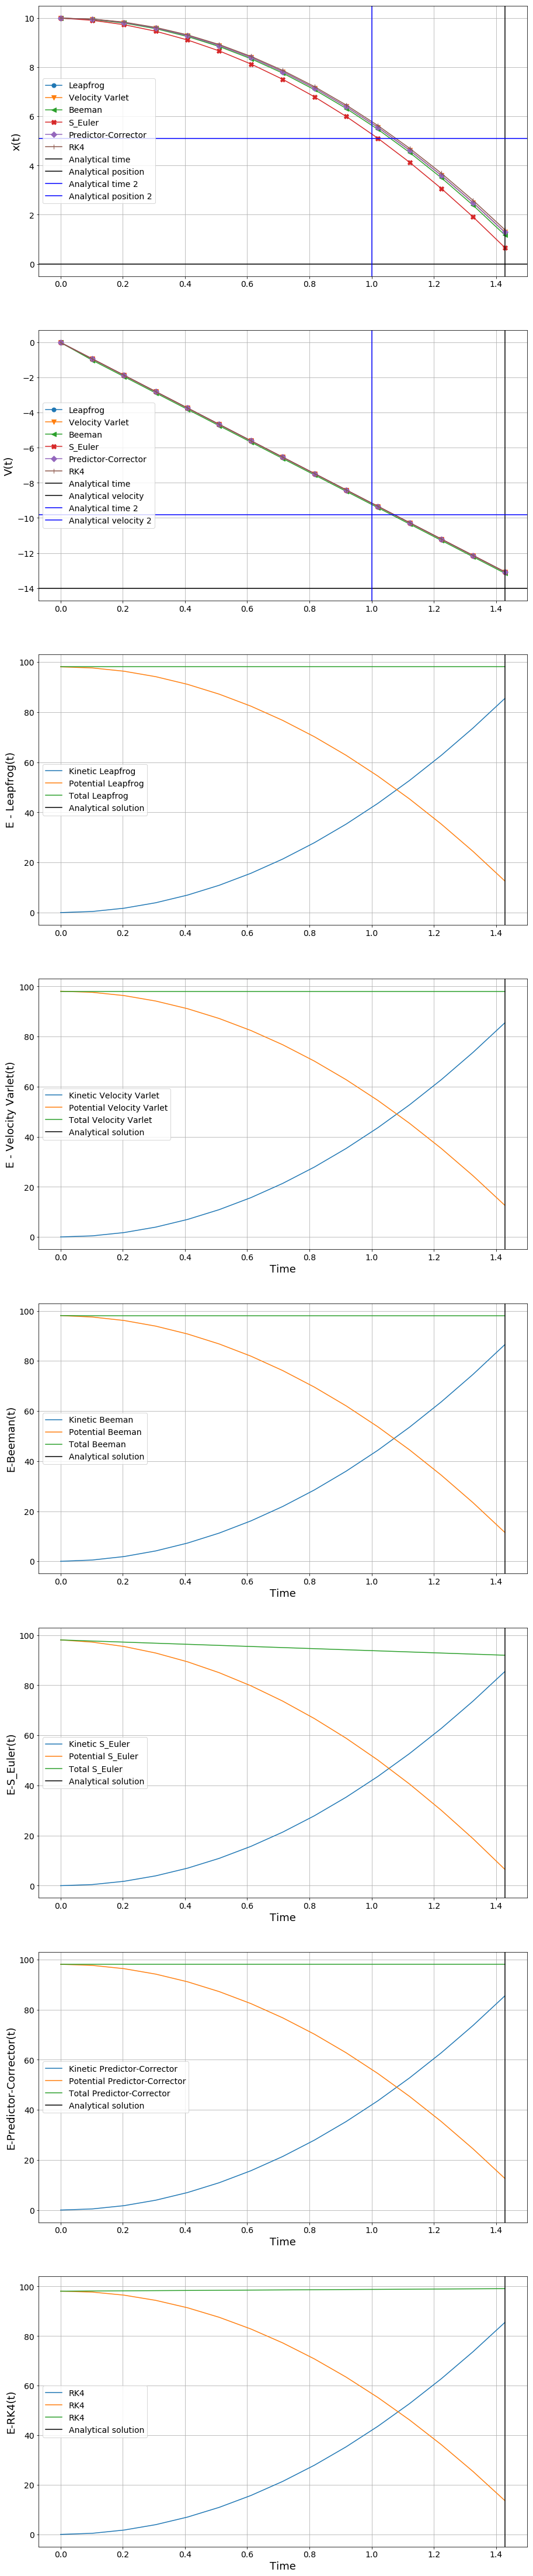

In [9]:
N = 15
x_0 = 10
v_0 = 0
acc = -9.81 #constant
drag_coefs = 0.25
# drag_force = False
drag_force = False
analytical_time_2 = 1.0


#Analytical time when object reaches 0m height
if not drag_force:
    analytical_velocity = np.sqrt((-2 * acc * x_0))
    analytical_time = analytical_velocity /(-1*acc)
    analytical_velocity_2 = 9.81  
    analytical_pose_2 = 5.095
else:
    analytical_velocity = 6.2430443663133
    analytical_time = 2.037908509576
    analytical_velocity_2 = 5.7404638911411
    analytical_pose_2 = 10 - 3.6624016100433

total_time = analytical_time
t = np.linspace(0, total_time, N)
dt = total_time / float(N)

###############################################################################
# numerical integration
x1, vh_1, vf_1, Ek1, Ep1, E1 = integrate_LF(acc, x_0, 0.0, dt, N, drag_force, drag_coefs) 
x2, vh_2, vf_2, Ek2, Ep2, E2 = integrate_VV(acc, x_0, 0.0, dt, N, drag_force, drag_coefs) 
x3, vh_3, vf_3, Ek3, Ep3, E3 = integrate_Beeman(acc, x_0, 0.0, dt, N, drag_force, drag_coefs)
x4, vh_4, vf_4, Ek4, Ep4, E4 = integrate_S_Euler(acc, x_0, 0.0, dt, N, drag_force, drag_coefs)
x5, vh_5, vf_5, Ek5, Ep5, E5 = integrate_PC(acc, x_0, 0.0, dt, N, drag_force, drag_coefs)
x6, vh_6, vf_6, Ek6, Ep6, E6 = integrate_RK4(acc, x_0, 0.0, dt, N, drag_force, drag_coefs)


print(x1[-1], "", vf_1[-1] , " ", t[-1], "Leapfrog      ")
print(x2[-1], "", vf_2[-1] , " ", t[-1], "Velocity Varlet")
print(x3[-1], "", vf_3[-1] , " ", t[-1], "Beeman     ")
print(x4[-1], "", vf_4[-1] , " ", t[-1], "S_Euler    ")
print(x5[-1], "", vf_5[-1] , " ", t[-1], "Predictor-Corrector    ")
print(x6[-1], "", vf_6[-1] , " ", t[-1], "Runge-Kutta 4th Order")

###############################################################################
plt.rcParams["axes.grid"] = True
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 18
plt.figure(figsize = [15, 80])

plt.subplot(811)
plt.plot(t,x1, marker='o', markersize = 7.15, label="Leapfrog")
plt.plot(t,x2, marker='v', markersize = 7.15, label="Velocity Varlet")
plt.plot(t,x3, marker='<', markersize = 7.15, label="Beeman")
plt.plot(t,x4, marker='X', markersize = 7.15, label="S_Euler")
plt.plot(t,x5, marker='D', markersize = 7.15, label="Predictor-Corrector")
plt.plot(t,x6, marker='|', markersize = 7.15, label="RK4")
plt.axvline(x = analytical_time, label = "Analytical time", c="black")
plt.axhline(y = 0, label = "Analytical position", c="black")
plt.axvline(x = analytical_time_2, label = "Analytical time 2", c="blue")
plt.axhline(y = analytical_pose_2, label = "Analytical position 2", c="blue")
plt.ylabel("x(t)")
plt.legend(loc="center left")

plt.subplot(812)
plt.plot(t,vf_1, marker='o', markersize = 7.05, label="Leapfrog")
plt.plot(t,vf_2, marker='v', markersize = 7.05, label="Velocity Varlet")
plt.plot(t,vf_3, marker='<', markersize = 7.05, label="Beeman")
plt.plot(t,vf_4, marker='X', markersize = 7.05, label="S_Euler")
plt.plot(t,vf_5, marker='D', markersize = 7.05, label="Predictor-Corrector")
plt.plot(t,vf_6, marker='|', markersize = 7.05, label="RK4")
plt.axvline(x = analytical_time, label = "Analytical time", c="black")
plt.axhline(y = -1 * analytical_velocity, label = "Analytical velocity", c="black")
plt.axvline(x = analytical_time_2, label = "Analytical time 2", c="blue")
plt.axhline(y = -1 * analytical_velocity_2, label = "Analytical velocity 2", c="blue")
plt.ylabel("V(t)")
plt.legend(loc="center left")

plt.subplot(813)
plt.plot(t,Ek1,label=r"Kinetic Leapfrog")
plt.plot(t,Ep1,label=r"Potential Leapfrog")
plt.plot(t,E1,label=r"Total Leapfrog")
plt.axvline(x=analytical_time, label = "Analytical solution", c="black")
plt.ylabel("E - Leapfrog(t)")
plt.legend(loc="center left")

plt.subplot(814)
plt.plot(t,Ek2,label=r"Kinetic Velocity Varlet")
plt.plot(t,Ep2,label=r"Potential Velocity Varlet")
plt.plot(t,E2,label=r"Total Velocity Varlet")
plt.axvline(x=analytical_time, label = "Analytical solution", c="black")
plt.ylabel("E - Velocity Varlet(t)")
plt.xlabel("Time")
plt.legend(loc="center left")

plt.subplot(815)
plt.plot(t,Ek3,label=r"Kinetic Beeman")
plt.plot(t,Ep3,label=r"Potential Beeman")
plt.plot(t,E3,label=r"Total Beeman")
plt.axvline(x=analytical_time, label = "Analytical solution", c="black")
plt.ylabel("E-Beeman(t)")
plt.xlabel("Time")
plt.legend(loc="center left")

plt.subplot(816)
plt.plot(t,Ek4,label=r"Kinetic S_Euler")
plt.plot(t,Ep4,label=r"Potential S_Euler")
plt.plot(t,E4,label=r"Total S_Euler")
plt.axvline(x=analytical_time, label = "Analytical solution", c="black")
plt.ylabel("E-S_Euler(t)")
plt.xlabel("Time")
plt.legend(loc="center left")

plt.subplot(817)
plt.plot(t,Ek5,label=r"Kinetic Predictor-Corrector")
plt.plot(t,Ep5,label=r"Potential Predictor-Corrector")
plt.plot(t,E5,label=r"Total Predictor-Corrector")
plt.axvline(x=analytical_time, label = "Analytical solution", c="black")
plt.ylabel("E-Predictor-Corrector(t)")
plt.xlabel("Time")
plt.legend(loc="center left")

plt.subplot(818)
plt.plot(t,Ek6,label=r"RK4")
plt.plot(t,Ep6,label=r"RK4")
plt.plot(t,E6,label=r"RK4")
plt.axvline(x=analytical_time, label = "Analytical solution", c="black")
plt.ylabel("E-RK4(t)")
plt.xlabel("Time")
plt.legend(loc="center left")

# plt.tight_layout()
plt.show()

In [10]:
###############################################################################
N = 10000
t = linspace(0,100,N)
dt = t[1] - t[0]

###############################################################################
# functions
def integrate(F,x0,v0,gamma):
    ###########################################################################
    # arrays are allocated and filled with zeros
    x = zeros(N)
    v = zeros(N)
    E = zeros(N)    
    
    ###########################################################################    
    # initial conditions
    x[0] = x0
    v[0] = v0
    
    ###########################################################################
    # integration
    fac1 = 1.0 - 0.5*gamma*dt
    fac2 = 1.0/(1.0 + 0.5*gamma*dt)
    
    for i in range(N-1):
        v[i + 1] = fac1*fac2*v[i] - fac2*dt*x[i] + fac2*dt*F[i]
        x[i + 1] = x[i] + dt*v[i + 1]
        E[i] = 0.5*(x[i]**2 + ((v[i] + v[i+1])/2.0)**2)
    
    E[-1] = 0.5*(x[-1]**2 + v[-1]**2)
    
    ###########################################################################
    # return solution
    return x,v,E

###############################################################################
# numerical integration
F = zeros(N)
x1,v1,E1 = integrate(F,0.0,1.0,0.0) # x0 = 0.0, v0 = 1.0, gamma = 0.0
x2,v2,E2 = integrate(F,0.0,1.0,0.05) # x0 = 0.0, v0 = 1.0, gamma = 0.01
x3,v3,E3 = integrate(F,0.0,1.0,0.4) # x0 = 0.0, v0 = 1.0, gamma = 0.5

###############################################################################
rcParams["axes.grid"] = True
rcParams['font.size'] = 14
rcParams['axes.labelsize'] = 18
figure()
subplot(211)
plot(t,x1)
plot(t,x2)
plot(t,x3)
ylabel("x(t)")

subplot(212)
plot(t,E1,label=r"$\gamma = 0.0$")
plot(t,E2,label=r"$\gamma = 0.01$")
plot(t,E3,label=r"$\gamma = 0.5$")
ylim(0,0.55)
ylabel("E(t)")

xlabel("Time")
legend(loc="center right")

tight_layout()

###############################################################################
# driven oscillator
def force(f0,t,w,T):
          return f0*cos(w*t)*exp(-t**2/T**2) 

F1 = zeros(N)
F2 = zeros(N)
F3 = zeros(N)
for i in range(N-1):
    F1[i] = force(1.0,t[i] - 20.0,1.0,10.0)
    F2[i] = force(1.0,t[i] - 20.0,0.9,10.0)
    F3[i] = force(1.0,t[i] - 20.0,0.8,10.0)

x1,v1,E1 = integrate(F1,0.0,0.0,0.0)
x2,v2,E2 = integrate(F2,0.0,0.0,0.0)
x3,v3,E3 = integrate(F3,0.0,0.0,0.0)

figure()
subplot(211)
plot(t,x1)
plot(t,x2)
plot(t,x3)
ylabel("x(t)")

subplot(212)
plot(t,E1,label=r"$\omega_0$")
plot(t,E2,label=r"$0.9\omega_0$")
plot(t,E3,label=r"$0.8\omega_0$")
ylabel("E(t)")

xlabel("Time")
rcParams['legend.fontsize'] = 16.0
legend(loc=(0.3,0.27),ncol=3)

###############################################################################
# oscillator driven at resonance plus damping
x1,v1,E1 = integrate(F1,0.0,0.0,0.0)
x2,v2,E2 = integrate(F1,0.0,0.0,0.01)
x3,v3,E3 = integrate(F1,0.0,0.0,0.1)

figure()
subplot(211)
plot(t,x1)
plot(t,x2)
plot(t,x3)
ylabel("x(t)")

subplot(212)
plot(t,E1,label=r"$\gamma = 0$")
plot(t,E2,label=r"$\gamma = 0.01$")
plot(t,E3,label=r"$\gamma = 0.1$")
ylabel("E(t)")

xlabel("Time")
rcParams['legend.fontsize'] = 14.0
legend(loc="upper left")

###############################################################################
show()
###############################################################################

NameError: name 'linspace' is not defined

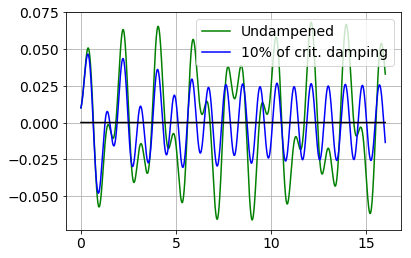

In [12]:
import numpy as np
import matplotlib.pyplot as plt
#source https://stackoverflow.com/questions/21958853/solving-ode-numerically-with-python

# This code solves the ODE mx'' + bx' + kx = F0*cos(Wd*t)
# m is the mass of the object in kg, b is the damping constant in Ns/m
# k is the spring constant in N/m, F0 is the driving force in N,
# Wd is the frequency of the driving force and x is the position 

# Setting up

timeFinal= 16.0   # This is how far the graph will go in seconds
steps = 10000     # Number of steps
dT = timeFinal/steps      # Step length 
time = np.linspace(0, timeFinal, steps+1)   
# Creates an array with steps+1 values from 0 to timeFinal

# Allocating arrays for velocity and position
vel = np.zeros(steps+1)
pos = np.zeros(steps+1)

# Setting constants and initial values for vel. and pos.
k = 0.1
m = 0.01
vel0 = 0.05
pos0 = 0.01
freqNatural = 10.0**0.5
b = 0.0
F0 = 0.01
Wd = 7.0
vel[0] = vel0    #Sets the initial velocity
pos[0] = pos0    #Sets the initial position



# Numerical solution using Euler's
# Splitting the ODE into two first order ones
# v'(t) = -(k/m)*x(t) - (b/m)*v(t) + (F0/m)*cos(Wd*t)
# x'(t) = v(t)
# Using the definition of the derivative we get
# (v(t+dT) - v(t))/dT on the left side of the first equation
# (x(t+dT) - x(t))/dT on the left side of the second 
# In the for loop t and dT will be replaced by i and 1

for i in range(0, steps):
    vel[i+1] = (-k/m)*dT*pos[i] + vel[i]*(1-dT*b/m) + (dT/m)*F0*np.cos(Wd*i*dT)
    pos[i+1] = dT*vel[i] + pos[i]

# Ploting
#----------------
# With no damping
plt.plot(time, pos, 'g-', label='Undampened')

# Damping set to 10% of critical damping
b = (freqNatural/50)*0.1

# Using Euler's again to compute new values for new damping
for i in range(0, steps):
    vel[i+1] = (-k/m)*dT*pos[i] + vel[i]*(1-(dT*(b/m))) + (F0*dT/m)*np.cos(Wd*i*dT)
    pos[i+1] = dT*vel[i] + pos[i]

plt.plot(time, pos, 'b-', label = '10% of crit. damping')
plt.plot(time, 0*time, 'k-')      # This plots the x-axis
plt.legend(loc = 'upper right')

#---------------
plt.show()

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


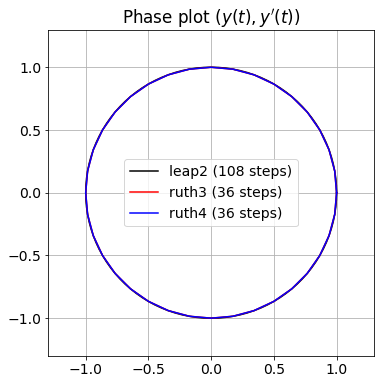

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def symplectic_integrate_step(qvt0, accel, dt, coeffs):
    q,v,t = qvt0
    for ai,bi in coeffs.T:
        v += bi * accel(q,v,t) * dt
        q += ai * v * dt
        t += ai * dt
    return q,v,t

def symplectic_integrate(qvt0, accel, t, coeffs):
    q = np.empty_like(t)
    v = np.empty_like(t)
    qvt = qvt0
    q[0] = qvt[0]
    v[0] = qvt[1]
    for i in range(1, len(t)):
        qvt = symplectic_integrate_step(qvt, accel, t[i]-t[i-1], coeffs)
        q[i] = qvt[0]
        v[i] = qvt[1]
    return q,v

c = np.math.pow(2.0, 1.0/3.0)
ruth4 = np.array([[0.5, 0.5*(1.0-c), 0.5*(1.0-c), 0.5],
                  [0.0,         1.0,          -c, 1.0]]) / (2.0 - c)
ruth3 = np.array([[2.0/3.0, -2.0/3.0, 1.0], [7.0/24.0, 0.75, -1.0/24.0]])
leap2 = np.array([[0.5, 0.5], [0.0, 1.0]])

accel = lambda q,v,t: -q
qvt0 = (1.0, 0.0, 0.0)
tmax = 2.0 * np.math.pi
N = 36

fig, ax = plt.subplots(1, figsize=(6, 6))
ax.axis([-1.3, 1.3, -1.3, 1.3])
ax.set_aspect('equal')
ax.set_title(r"Phase plot $(y(t),y'(t))$")
ax.grid(True)
t = np.linspace(0.0, tmax, 3*N+1)
q,v = symplectic_integrate(qvt0, accel, t, leap2)
ax.plot(q, v, label='leap2 (%d steps)' % (3*N), color='black')
t = np.linspace(0.0, tmax, N+1)
q,v = symplectic_integrate(qvt0, accel, t, ruth3)
ax.plot(q, v, label='ruth3 (%d steps)' % N, color='red')
q,v = symplectic_integrate(qvt0, accel, t, ruth4)
ax.plot(q, v, label='ruth4 (%d steps)' % N, color='blue')
ax.legend(loc='center')
fig.show()


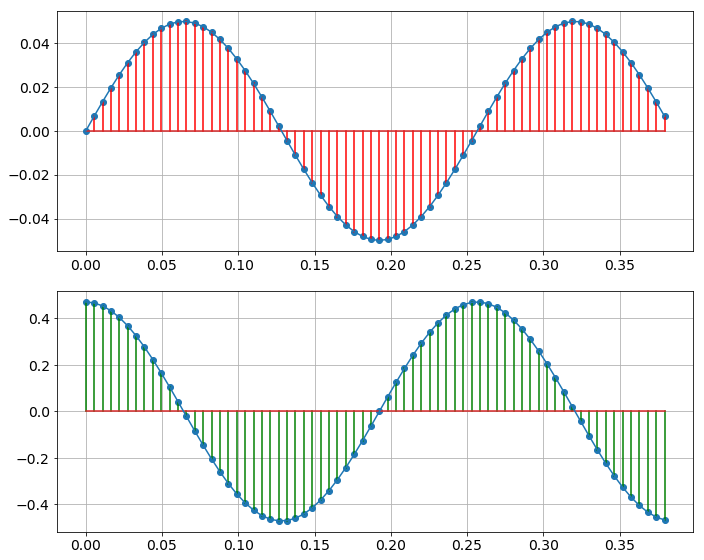

In [14]:
### Sine wave with constant frequency
fs = 70# sample rate 
f = 1.5 # the frequency of the signal
amplitude = 0.05
# scale = 1.0
scale = 0.0055

x = np.arange(fs)  # the points on the x axis for plotting
# compute the value (amplitude) of the sin wave at the for each sample
y = amplitude * np.sin(2 * np.pi * f * (x/fs)) 
y_d = amplitude * np.cos(2 * np.pi * f * (x/fs)) * 2 * np.pi * f

x = x * scale 

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(211)
plt.stem(x,y, 'r', )
plt.plot(x,y)
ax = fig.add_subplot(212)
plt.stem(x,y_d, 'g', )
plt.plot(x,y_d)
plt.tight_layout()

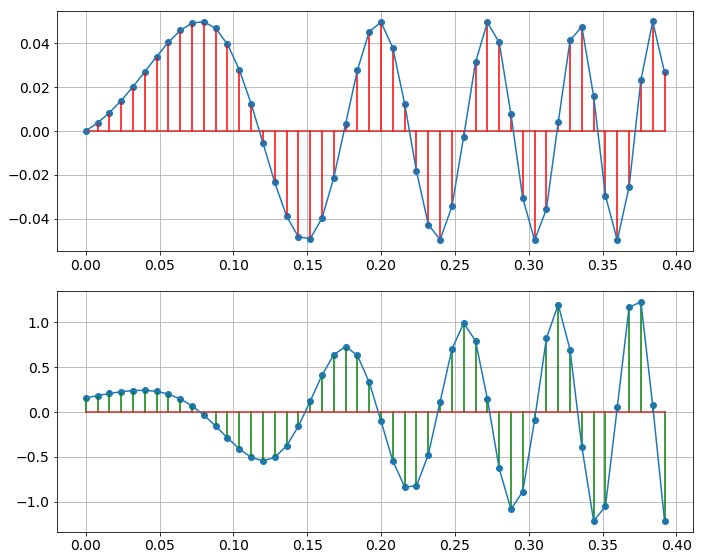

In [15]:
### Chirp Sine wave with increasing frequency
fs = 50# sample rate 
f = 0.5 # the frequency of the signal
f_T = 4.5
amplitude = 0.05
# scale = 1.0
scale = 0.008

freq = np.linspace(f, f_T, fs, endpoint=True) # Chirp times
x = np.arange(fs)  # the points on the x axis for plotting
f_d = (f_T - f) / (fs - 1)

# compute the value (amplitude) of the sin wave at the for each sample
y = amplitude * np.sin(2 * np.pi * freq * (x/fs)) 
y_d = amplitude * np.cos(2 * np.pi * freq * (x/fs)) * 2 * np.pi * (f_d * (x/fs) + freq)

x = x * scale 

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(211)
plt.stem(x,y, 'r', )
plt.plot(x,y)

ax = fig.add_subplot(212)
plt.stem(x,y_d, 'g', )
plt.plot(x,y_d)
plt.tight_layout()

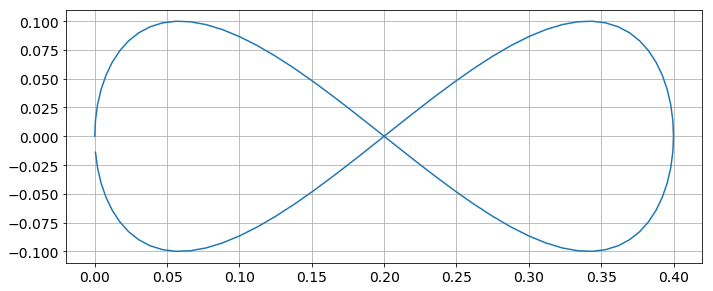

In [16]:
### Infinity sign wave with increasing frequency

fs = 90# sample rate 
f = 1.5 # the frequency of the signal
f_T = 8.5
amplitude = 1.0
scale = 1.0
# scale = 0.35
x_r = 0.4
x_l = 0.0
y_u = 0.2
y_d = 0.0

freq = np.linspace(f, f_T, fs) # Chirp times.

t = np.arange(fs)  # the points on the x axis for plotting
# amplitude = 2 / (3 - np.cos(4*np.pi * t / fs))

x = scale *  amplitude * ((x_l - x_r)/2) * np.cos(2 * np.pi * t / fs) + (x_r + x_l)/2
y = amplitude * ((y_u - y_d)/2) * np.sin(4 * np.pi * t/fs)# + y_u 

x_d = scale * -1 * amplitude * ((x_r - x_l)/2) * np.sin(2 * np.pi * t/fs) * 2 * np.pi / fs 
y_d = amplitude * ((y_u - y_d)/4) * np.cos(4 * np.pi * t / fs) * 4 * np.pi / fs * freq

fig = plt.figure(figsize=(10,8))
#this instruction can only be used with IPython Notbook. 
# showing the exact location of the smaples
ax = fig.add_subplot(211)
# plt.stem(x,y, 'r', )
plt.plot(x,y)
plt.grid(True)
# ax = fig.add_subplot(212)
# plt.stem(t,y_d, 'g', )
# plt.plot(t,y_d)

plt.tight_layout()

11
70


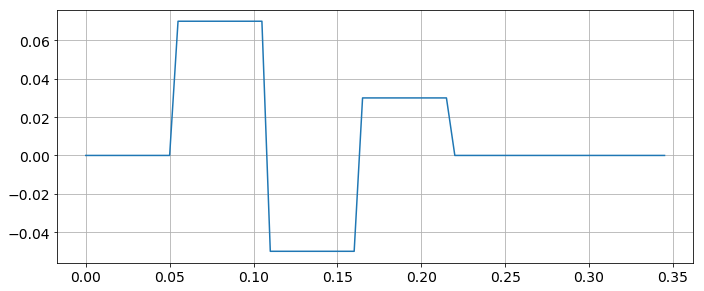

In [17]:
### Step function 
### Infinity sign wave with increasing frequency

fs = 70# sample rate 
step_size = 6
scale = 0.005

x = np.arange(fs) * scale  # the points on the x axis for plotting
y = np.zeros(fs)
offset = int(x.size / step_size)
print(offset)

for i in range(offset):
    y[i] = 0.0

for i in range(offset):
    y[offset + i] = 0.07

for i in range(offset):
    y[2 * offset + i] = -0.05
    
for i in range(offset):
    y[3 * offset + i] = 0.03  
    
print(y.size)
fig = plt.figure(figsize=(10,8))
#this instruction can only be used with IPython Notbook. 
# showing the exact location of the smaples
ax = fig.add_subplot(211)
# plt.stem(x,y, 'r', )
plt.plot(x,y)
plt.grid(True)

plt.tight_layout()

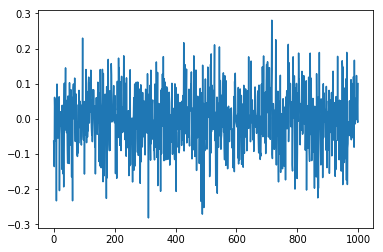

In [48]:
import numpy as np
import matplotlib.pyplot as plt
mu, sigma = 0, 0.08 # mean and standard deviation
random_data= np.random.normal(mu, sigma, 1000)
plt.plot(random_data)
plt.show()

In [2]:
def sine_generator(fs, sinefreq, duration):
    T = duration
    nsamples = fs * T
    w = 2. * np.pi * sinefreq
    t_sine = np.linspace(0, T, nsamples, endpoint=False)
    y_sine = np.sin(w * t_sine)

    return t_sine, y_sine

In [3]:
def highpass_filter(raw_data, high_alpha):
    high_data = np.copy(raw_data)

    for i in range(1, len(raw_data)):
        high_data[i] = high_alpha * (high_data[i-1] + raw_data[i] - raw_data[i-1])
    return high_data

In [4]:
def lowpass_filter(data, alpha):
    low_data = np.copy(data)

    low_data[0] = (1.0 - alpha) * data[0]
    for i in range(1, len(data)):
        low_data[i] = alpha * low_data[i-1] + (1.0 - alpha) * data[i]
    return low_data

In [5]:
from __future__ import division
import collections
import math

class RunningStats:
    def __init__(self, WIN_SIZE=20):
        self.n = 0
        self.mean = 0
        self.run_var = 0
        self.WIN_SIZE = WIN_SIZE

        self.windows = collections.deque(maxlen=WIN_SIZE+1)

    def clear(self):
        self.n = 0
        self.windows.clear()

    def push(self, x):

        self.windows.append(x)

        if self.n <= self.WIN_SIZE:
            # Calculating first variance
            self.n += 1
            delta = x - self.mean
            self.mean += delta / self.n
            self.run_var += delta * (x - self.mean)
        else:
            # Adjusting variance
            x_removed = self.windows.popleft()
            old_m = self.mean
            self.mean += (x - x_removed) / self.WIN_SIZE
            self.run_var += (x + x_removed - old_m - self.mean) * (x - x_removed)

    def get_mean(self):
        return self.mean if self.n else 0.0

    def get_var(self):
        return self.run_var / (len(self.windows)) if self.n > 1 else 0.0

    def get_std(self):
        return math.sqrt(self.get_var())

    def get_all(self):
        return list(self.windows)

    def __str__(self):
        return "Current window values: {}".format(list(self.windows))

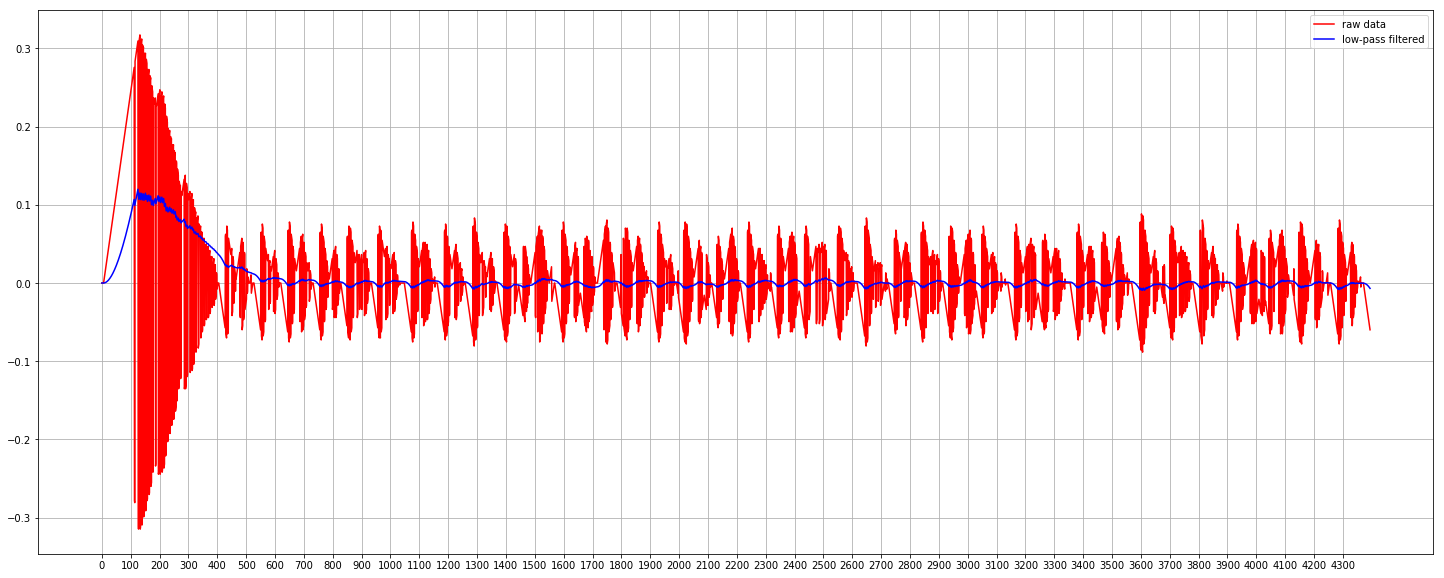

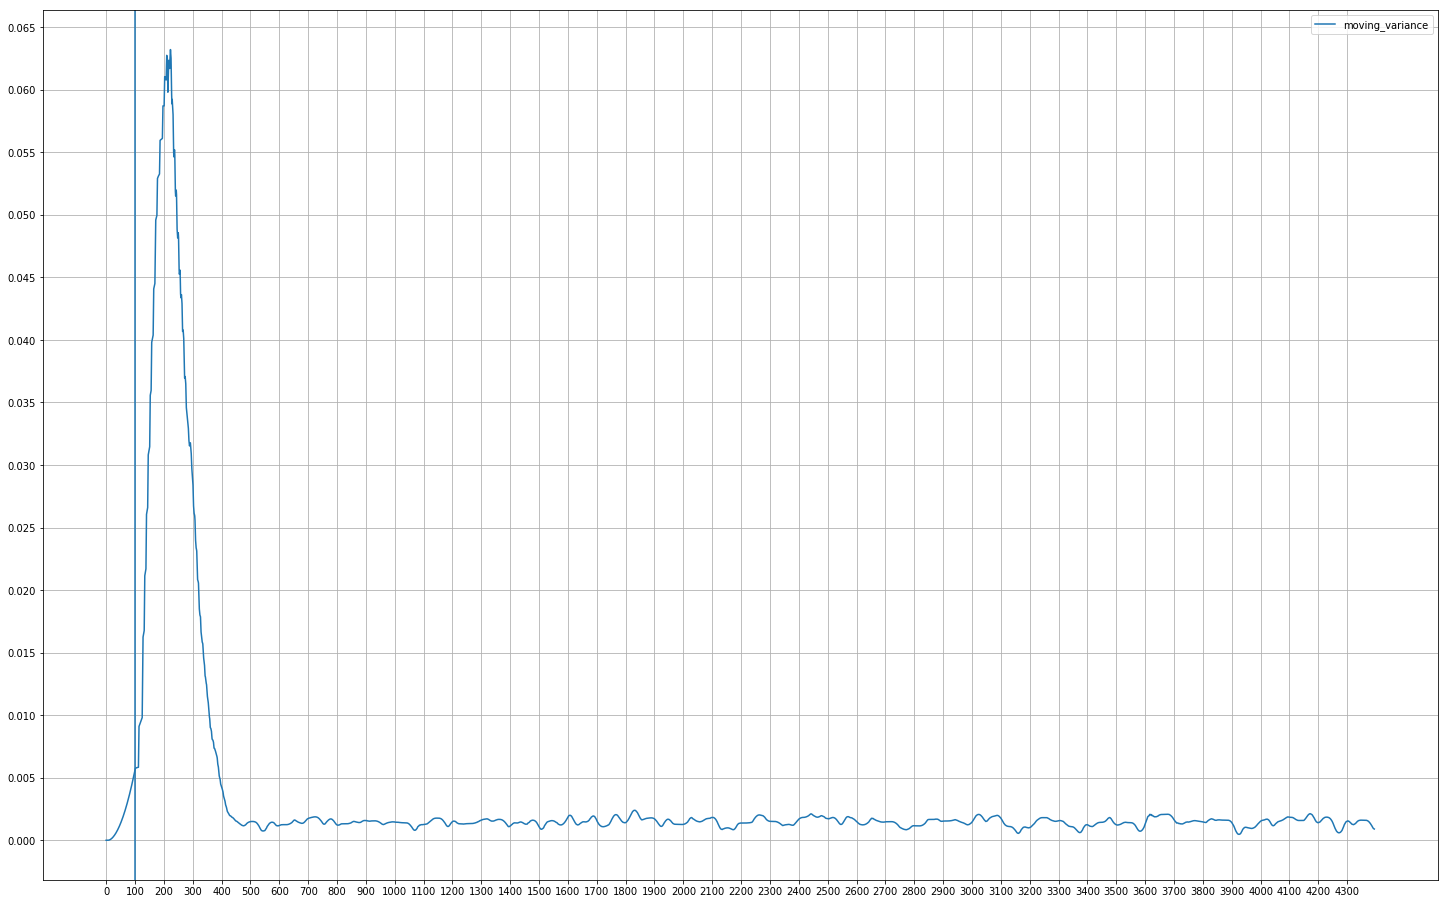

In [46]:
fps = 30
sine_fq = 10 #Hz
duration = 10 #seconds
t_sine5, y_sine5 = sine_generator(fps, sine_fq, duration)
y_sine5 = random_data[:300] + y_sine5
y_1 = y_sine5
y_2 = y_sine5

f=open("gain_signal.txt", "r")
lines = f.read().strip().split("\n")
gain_signal = np.float32(np.array(lines))
f.close()
alpha_low = 0.99
alpha_high = 0.3

plt.figure(figsize=(25,10))
major_ticks = np.arange(0, len(gain_signal), 100)
minor_ticks = np.arange(-1, 1, 0.1)
plt.xticks(major_ticks)
plt.yticks(minor_ticks)

plt.plot(gain_signal, c= 'red', label = "raw data")

low_sine5 = lowpass_filter(gain_signal, alpha_low)
plt.plot(low_sine5, c= 'blue', label = "low-pass filtered")
# high_sine5 = highpass_filter(gain_signal, alpha_high)
# plt.plot(high_sine5, c= 'green', label = "high-pass filtered")
plt.grid()
plt.legend()
plt.show()

win_size = 100
var_calc = RunningStats(win_size)
moving_var = []
for i, step in enumerate(gain_signal):
    var_calc.push(step)
    moving_var.append(var_calc.get_var())
moving_var = np.array(moving_var)

plt.figure(figsize=(25,16))
plt.xticks(major_ticks)
minor_ticks = np.arange(0, 0.7, 0.005)
plt.yticks(minor_ticks)
plt.axvline(x=win_size)
plt.plot(moving_var, label = "moving_variance")
plt.grid()
plt.legend()
plt.show()

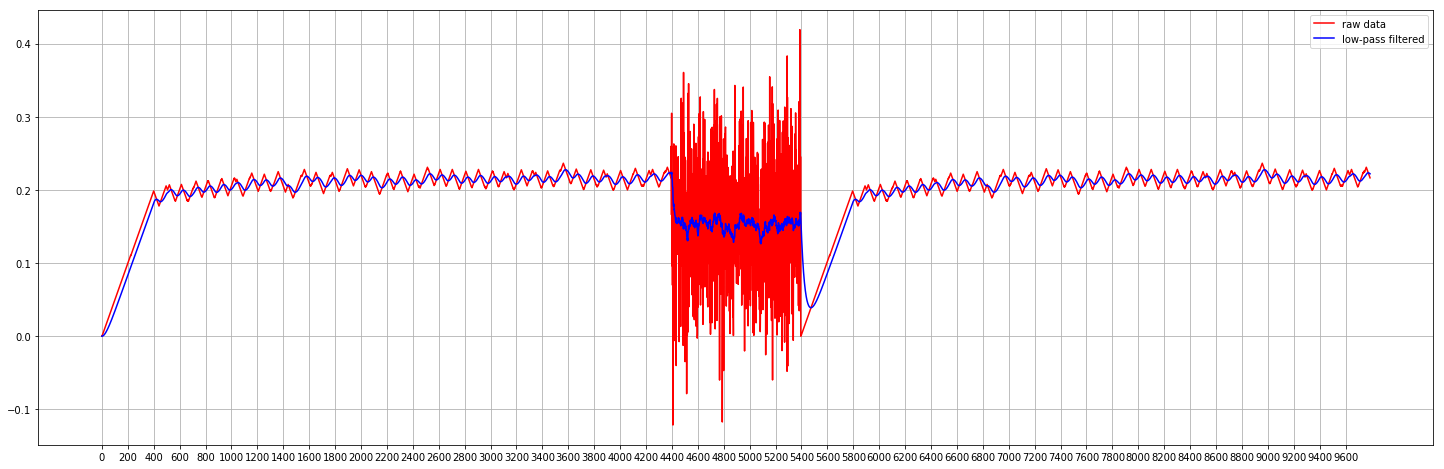

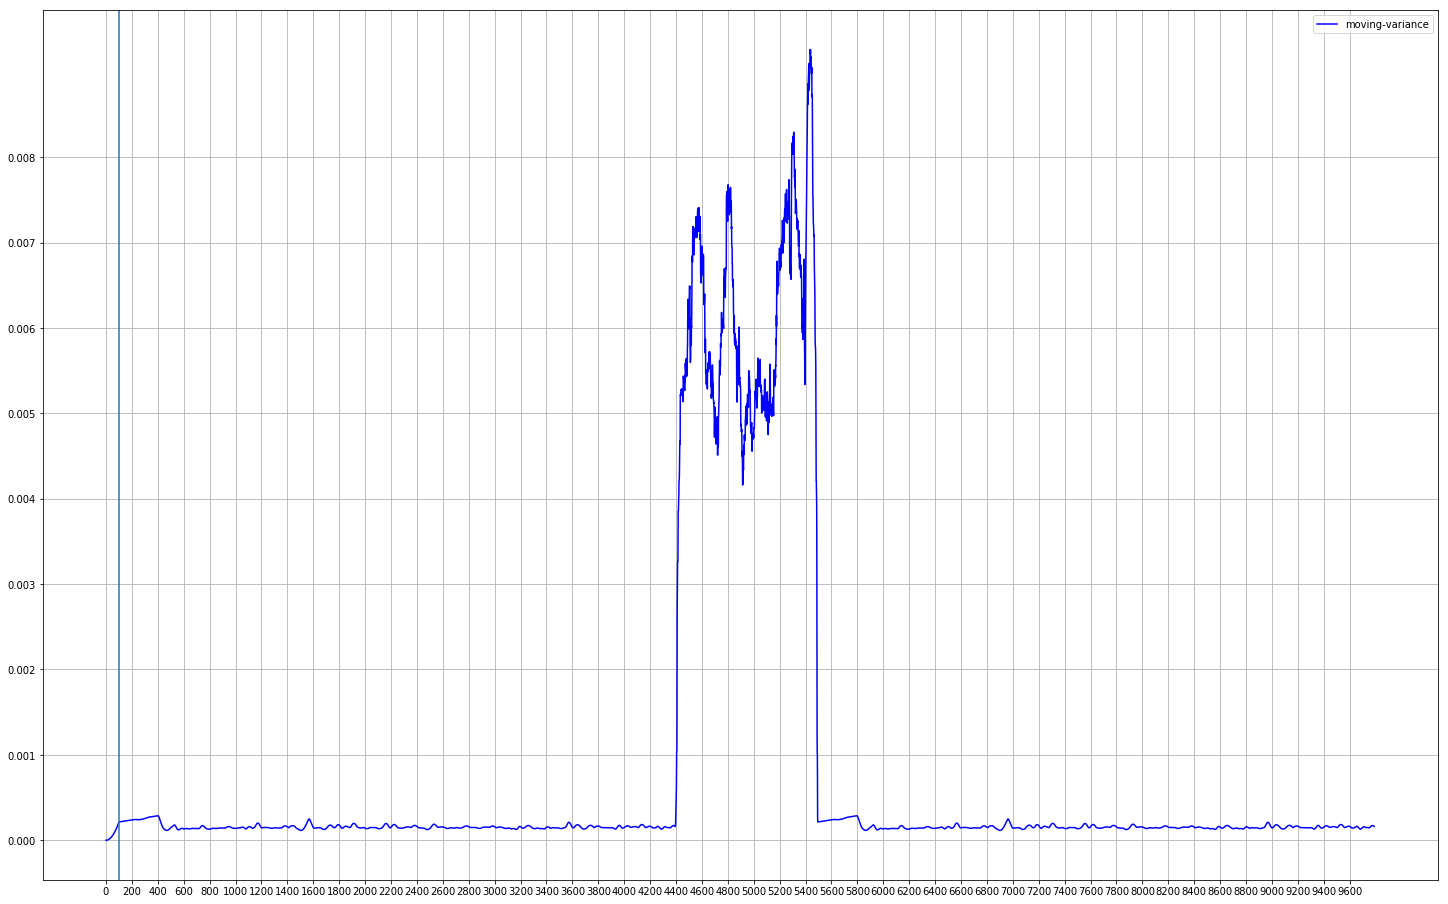

In [44]:
f=open("bias_signal.txt", "r")
lines = f.read().strip().split("\n")
bias_signal_1 = np.array(np.float32(lines))
f.close()
bias_signal = np.concatenate((bias_signal_1, np.array(0.15 + random_data)), axis=None)
bias_signal = np.concatenate((bias_signal, bias_signal_1), axis=None)
alpha_low = 0.97
alpha_high = 0.1

plt.figure(figsize=(25,8))
major_ticks = np.arange(0, len(bias_signal), 200)
minor_ticks = np.arange(-1, 1, 0.1)
plt.xticks(major_ticks)
plt.yticks(minor_ticks)
plt.plot(bias_signal, c= 'red', label = "raw data")

low_sine5 = lowpass_filter(bias_signal, alpha_low)
plt.plot(low_sine5, c= 'blue', label = "low-pass filtered")

# high_sine5 = highpass_filter(bias_signal, alpha_high)
# plt.plot(high_sine5, c= 'green', label = "high-pass filtered")
plt.grid()
plt.legend()
plt.show()

win_size = 100
var_calc = RunningStats(win_size)
moving_var = []
for i, step in enumerate(bias_signal):
    var_calc.push(step)
    moving_var.append(var_calc.get_var())
moving_var = np.array(moving_var)

plt.figure(figsize=(25,16))
plt.plot(moving_var, c= 'blue', label = "moving-variance")
plt.xticks(major_ticks)
minor_ticks = np.arange(0, 0.009, 0.001)
plt.yticks(minor_ticks)
plt.axvline(x=win_size)
plt.grid()
plt.legend()
plt.show()